In [59]:
# Install library kaggle
!pip install -q kaggle pandas

import os
import json # Added to parse kaggle.json

# Konfigurasi Kaggle (Pastikan kaggle.json sudah diupload)
kaggle_config_dir = '/root/.kaggle'
kaggle_json_path = os.path.join(kaggle_config_dir, 'kaggle.json')
source_kaggle_json = 'kaggle.json' # Assumes kaggle.json is in /content/

# Create .kaggle directory if it doesn't exist
if not os.path.exists(kaggle_config_dir):
    os.makedirs(kaggle_config_dir)

# Copy kaggle.json from /content/ to /root/.kaggle/ and set permissions
if os.path.exists(source_kaggle_json):
    print(f"Mengcopy {source_kaggle_json} ke {kaggle_config_dir}/")
    !cp {source_kaggle_json} {kaggle_config_dir}/
    !chmod 600 {kaggle_json_path}

    # Verify kaggle.json content
    if not os.path.exists(kaggle_json_path):
        print(f"Error: {kaggle_json_path} tidak ditemukan setelah disalin.")
    elif os.path.getsize(kaggle_json_path) == 0:
        print(f"Error: {kaggle_json_path} kosong. Pastikan file kaggle.json Anda berisi kredensial API yang valid.")
    else:
        try:
            with open(kaggle_json_path, 'r') as f:
                config = json.load(f)
            if 'username' not in config or 'key' not in config:
                print(f"Error: {kaggle_json_path} tidak memiliki 'username' atau 'key'. Harap periksa isinya.")
            else:
                print("Kaggle configuration successful.")
        except json.JSONDecodeError:
            print(f"Error: {kaggle_json_path} bukan file JSON yang valid. Harap periksa isinya.")
        except Exception as e:
            print(f"Terjadi kesalahan saat memeriksa {kaggle_json_path}: {e}")
else:
    print(f"Error: {source_kaggle_json} tidak ditemukan di direktori saat ini ({os.getcwd()}). Harap unggah file kaggle.json Anda.")

# Download Dataset CelebA (jika belum ada)
if not os.path.exists('img_align_celeba'):
    print("Mendownload dataset CelebA...")
    !kaggle datasets download -d kushsheth/face-vae
    print("Mengekstrak dataset...")
    # This command will only succeed if celeba-dataset.zip was downloaded
    !unzip -q face-vae.zip'
    print("Selesai!")
else:
    print("Dataset sudah ada.")

Mengcopy kaggle.json ke /root/.kaggle/
Kaggle configuration successful.
Dataset sudah ada.


In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# --- KONFIGURASI ---
BATCH_SIZE = 64 # Turunkan jika OOM (Out of Memory)
IMG_SHAPE = (64, 64, 3)
LATENT_DIM = 128
NUM_CLASSES = 2 # Binary: Male vs Female (atau atribut lain)
EPOCHS = 20     # Sesuaikan dengan waktu Anda (WGAN butuh waktu lama)

# --- 1. DATA LOADING CELEBA ---
print("Meniapkan Data Pipeline...")

# Baca atribut
attr_df = pd.read_csv("list_attr_celeba.csv", encoding='latin1')
# Kita ambil atribut 'Male' sebagai target label (-1: Female, 1: Male)
# Ubah label -1 menjadi 0 agar formatnya [0, 1]
attr_df['label'] = (attr_df['Male'] + 1) // 2 # Fixed: changed 'images' to 'Male'
attr_df = attr_df[['image_id', 'label']]

# Pastikan base_path benar
base_path = "/content/img_align_celeba/img_align_celeba"
# Verifikasi satu sampel path
sample_path = os.path.join(base_path, attr_df['image_id'].iloc[0])
print(f"Mengecek path contoh: {sample_path}")

if not os.path.exists(sample_path):
    print("PERINGATAN: File gambar tidak ditemukan! Periksa struktur folder unzip Anda.")

# Untuk demo praktikum, kita ambil sebagian data saja (misal 30.000) agar cepat
# Hapus [:30000] jika ingin menggunakan seluruh dataset (200k gambar)
data_limit = 30000
image_paths = image_paths[:data_limit]
labels = labels[:data_limit]

# Fungsi Preprocessing
def load_and_preprocess(img_path, label):
    # Baca file gambar
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize & Crop Center (agar wajah proporsional)
    img = tf.image.resize(img, [64, 64])
    # Normalize ke [-1, 1]
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    return img, label

# Buat tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap. Jumlah batch: {len(dataset)}")

Meniapkan Data Pipeline...
Mengecek path contoh: /content/img_align_celeba/img_align_celeba/000001.jpg
Dataset siap. Jumlah batch: 468


In [61]:
# --- 2. BUILD CRITIC (DISCRIMINATOR) ---
def build_critic(image_shape, num_classes):
    # Input Gambar
    img_input = layers.Input(shape=image_shape)

    # Input Label (Embedding -> Spasial)
    label_input = layers.Input(shape=(1,))
    # Embed label ke dimensi spasial (64x64)
    label_embedding = layers.Embedding(num_classes, image_shape[0]*image_shape[1])(label_input)
    label_embedding = layers.Reshape((image_shape[0], image_shape[1], 1))(label_embedding)

    # Gabungkan (Concatenate) Gambar + Label
    merged = layers.Concatenate(axis=-1)([img_input, label_embedding])

    # Arsitektur Konvolusi
    x = layers.Conv2D(64, 4, strides=2, padding="same")(merged)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x) # Output Linear (Score) untuk WGAN

    return models.Model([img_input, label_input], output, name="Critic")

# --- 3. BUILD GENERATOR ---
def build_generator(latent_dim, num_classes):
    # Input Noise
    z_input = layers.Input(shape=(latent_dim,))

    # Input Label
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    # Gabungkan Noise + Label
    merged = layers.Concatenate()([z_input, label_embedding])

    # Upsampling
    x = layers.Dense(4 * 4 * 512)(merged)
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same")(x) # 8x8
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same")(x) # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same")(x) # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output Layer (64x64x3) -> Tanh activation
    output = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)

    return models.Model([z_input, label_input], output, name="Generator")

In [62]:
# --- 4. GRADIENT PENALTY ---
def gradient_penalty(batch_size, real_images, fake_images, labels, critic):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # Critic menerima [gambar, label]
        pred = critic([interpolated, labels], training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# --- 5. MODEL WGAN-GP UTAMA ---
class WGAN_GP_CGAN(keras.Model):
    def __init__(self, generator, critic, latent_dim, gp_weight=10.0):
        super().__init__()
        self.generator = generator
        self.critic = critic
        self.latent_dim = latent_dim
        self.gp_weight = gp_weight

        # Trackers
        self.c_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_tracker, self.g_loss_tracker]

    def compile(self, c_optimizer, g_optimizer):
        super().compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def train_step(self, data):
        # Unpack data (Image, Label) dari dataset
        real_images, labels = data

        batch_size = tf.shape(real_images)[0]

        # ---------------------
        #  Latih Critic (5x)
        # ---------------------
        for _ in range(5):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                # Generate Gambar Palsu (conditioned on labels)
                fake_images = self.generator([random_latent_vectors, labels], training=True)

                # Prediksi Critic
                real_logits = self.critic([real_images, labels], training=True)
                fake_logits = self.critic([fake_images, labels], training=True)

                # Wasserstein Loss
                c_wass_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

                # Gradient Penalty
                c_gp = gradient_penalty(batch_size, real_images, fake_images, labels, self.critic)

                # Total Critic Loss
                c_loss = c_wass_loss + self.gp_weight * c_gp

            # Update Critic
            c_grads = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_grads, self.critic.trainable_variables))

        # ---------------------
        #  Latih Generator (1x)
        # ---------------------
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, labels], training=True)
            fake_logits = self.critic([fake_images, labels], training=True)

            # Generator Loss (maximize critic prediction for fake)
            g_loss = -tf.reduce_mean(fake_logits)

        # Update Generator
        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # Update Metrics
        self.c_loss_tracker.update_state(c_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "c_loss": self.c_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# --- 6. CALLBACK MONITORING (REVISED) ---
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # Pre-seed noise and labels so we can see evolution on the same faces
        self.seed_latent = tf.random.normal(shape=(num_img * 2, latent_dim))
        self.seed_labels = np.array([0] * num_img + [1] * num_img).reshape(-1, 1)

    def on_epoch_end(self, epoch, logs=None):
        # Generate images using the fixed seed
        generated_images = self.model.generator([self.seed_latent, self.seed_labels], training=False)

        # DENORMALIZATION LOGIC:
        # If your generator ends with 'tanh', images are in range [-1, 1].
        # We scale them back to [0, 255] for display.
        generated_images = (generated_images + 1.0) * 127.5
        generated_images = np.clip(generated_images, 0, 255).astype("uint8")

        fig = plt.figure(figsize=(12, 6))
        for i in range(self.num_img * 2):
            plt.subplot(2, self.num_img, i + 1)
            # Handle grayscale vs RGB
            if generated_images.shape[-1] == 1:
                plt.imshow(generated_images[i, :, :, 0], cmap="gray")
            else:
                plt.imshow(generated_images[i])

            plt.axis("off")
            gender = "Female" if i < self.num_img else "Male"
            plt.title(f"Label {self.seed_labels[i][0]}: {gender}")

        plt.suptitle(f"Generated Images - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()
        plt.close() # Close to prevent memory accumulation in notebooks

# --- 7. INISIALISASI & TRAIN ---

# Ensure constants are defined
# LATENT_DIM = 128
# NUM_CLASSES = 2
# IMG_SHAPE = (64, 64, 3)

generator = build_generator(LATENT_DIM, NUM_CLASSES)
critic = build_critic(IMG_SHAPE, NUM_CLASSES)

# Important Check: Ensure your generator's last layer is:
# layers.Conv2DTranspose(..., activation='tanh')

wgan = WGAN_GP_CGAN(generator=generator, critic=critic, latent_dim=LATENT_DIM)

# Optimizer WGAN-GP configuration
# WGAN-GP is sensitive to learning rates. 0.0001 is often more stable than 0.0002.
c_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)
g_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)

wgan.compile(
    c_optimizer=c_opt,
    g_optimizer=g_opt
)

print("Starting Training...")
# Note: Ensure your 'dataset' yields images normalized to [-1, 1]
# example: ds = ds.map(lambda x, y: ((tf.cast(x, tf.float32) - 127.5) / 127.5, y))

wgan.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=4, latent_dim=LATENT_DIM)]
)

Starting Training...
Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -54.5843 - g_loss: -45.7728

ValueError: In a nested call() argument, you cannot mix tensors and non-tensors. Received invalid mixed argument: inputs=[<tf.Tensor: shape=(8, 128), dtype=float32, numpy=
array([[-1.0624553 ,  0.3497683 , -0.35837325, ...,  0.5931848 ,
        -0.7184323 ,  0.8124669 ],
       [ 0.918934  ,  1.1895981 ,  0.77291864, ...,  2.0141842 ,
         0.28160354, -0.43033394],
       [-1.5919132 ,  1.560635  , -0.1111675 , ...,  1.5154586 ,
         1.1239105 , -1.4362729 ],
       ...,
       [ 0.28949735,  1.1754227 ,  0.36719003, ..., -1.3616707 ,
         0.78758174, -0.131722  ],
       [-0.7912594 , -0.26619956, -0.49378958, ..., -0.62922585,
        -0.24583618,  0.06453946],
       [ 1.5354143 ,  0.22532128, -3.2787716 , ..., -1.2471817 ,
        -1.5698503 ,  0.26582125]], dtype=float32)>, array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])]

# Task
To fix the `NotFoundError` during model training, I will first modify the cell `vSD6Jnn7Plwp` to correctly construct the `image_paths` using the `base_path`. Then, I will re-run `vSD6Jnn7Plwp` to update the data pipeline, and finally, re-run `JagfaG62P5wJ` to continue training the WGAN-GP model.

```python
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os # Ensure os is imported for path operations

# --- KONFIGURASI ---
BATCH_SIZE = 32 # Turunkan jika OOM (Out of Memory)
IMG_SHAPE = (64, 64, 3)
LATENT_DIM = 128
NUM_CLASSES = 2 # Binary: Male vs Female (atau atribut lain)
EPOCHS = 20     # Sesuaikan dengan waktu Anda (WGAN butuh waktu lama)

# --- 1. DATA LOADING CELEBA ---
print("Meniapkan Data Pipeline...")

# Baca atribut
attr_df = pd.read_csv("list_attr_celeba.csv", encoding='latin1')
# Kita ambil atribut 'Male' sebagai target label (-1: Female, 1: Male)
# Ubah label -1 menjadi 0 agar formatnya [0, 1]
attr_df['label'] = (attr_df['Male'] + 1) // 2
attr_df = attr_df[['image_id', 'label']]

# Pastikan base_path benar
base_path = "/content/img_align_celeba/img_align_celeba"

# Secara eksplisit membuat daftar path gambar dengan menggabungkan base_path
image_paths = [os.path.join(base_path, img_id) for img_id in attr_df['image_id']]
# Secara eksplisit membuat daftar label
labels = attr_df['label'].values

# Verifikasi satu sampel path
sample_path = image_paths[0] # Use the newly created list for sample check
print(f"Mengecek path contoh: {sample_path}")

if not os.path.exists(sample_path):
    print("PERINGATAN: File gambar tidak ditemukan! Periksa struktur folder unzip Anda.")
    # Add a check to print a few problematic paths if the sample path fails
    print("Beberapa path gambar yang mungkin salah:")
    for i in range(min(5, len(image_paths))):
        if not os.path.exists(image_paths[i]):
            print(f"- {image_paths[i]} (TIDAK DITEMUKAN)")


# Untuk demo praktikum, kita ambil sebagian data saja (misal 30.000) agar cepat
# Hapus [:30000] jika ingin menggunakan seluruh dataset (200k gambar)
data_limit = 30000
image_paths = image_paths[:data_limit]
labels = labels[:data_limit]


# Fungsi Preprocessing
def load_and_preprocess(img_path, label):
    # Baca file gambar
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize & Crop Center (agar wajah proporsional)
    img = tf.image.resize(img, [64, 64])
    # Normalize ke [-1, 1]
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    return img, label

# Buat tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap. Jumlah batch: {len(dataset)}")
```

## Perbaiki Pembentukan Image Paths

### Subtask:
Modifikasi sel `vSD6Jnn7Plwp` untuk secara eksplisit membuat daftar `image_paths` dengan menggabungkan `base_path` (yang sudah benar) dengan `image_id` dari `attr_df`, dan kemudian membuat `labels` dari `attr_df`.


**Reasoning**:
The subtask requires modifying cell `vSD6Jnn7Plwp` to correctly construct `image_paths` and `labels` by explicitly joining `base_path` with `image_id` and extracting labels from `attr_df`. The provided code snippet will be used for this modification, and I will ensure `os` is imported.



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os # Ensure os is imported here

# --- KONFIGURASI ---
BATCH_SIZE = 32 # Turunkan jika OOM (Out of Memory)
IMG_SHAPE = (64, 64, 3)
LATENT_DIM = 128
NUM_CLASSES = 2 # Binary: Male vs Female (atau atribut lain)
EPOCHS = 20     # Sesuaikan dengan waktu Anda (WGAN butuh waktu lama)

# --- 1. DATA LOADING CELEBA ---
print("Meniapkan Data Pipeline...")

# Baca atribut
attr_df = pd.read_csv("list_attr_celeba.csv", encoding='latin1')
# Kita ambil atribut 'Male' sebagai target label (-1: Female, 1: Male)
# Ubah label -1 menjadi 0 agar formatnya [0, 1]
attr_df['label'] = (attr_df['Male'] + 1) // 2
attr_df = attr_df[['image_id', 'label']]

# Pastikan base_path benar
base_path = "/content/img_align_celeba/img_align_celeba"

# Secara eksplisit membuat daftar path gambar dengan menggabungkan base_path
image_paths = [os.path.join(base_path, img_id) for img_id in attr_df['image_id']]
# Secara eksplisit membuat daftar label
labels = attr_df['label'].values

# Verifikasi satu sampel path
sample_path = image_paths[0] # Use the newly created list for sample check
print(f"Mengecek path contoh: {sample_path}")

if not os.path.exists(sample_path):
    print("PERINGATAN: File gambar tidak ditemukan! Periksa struktur folder unzip Anda.")
    # Add a check to print a few problematic paths if the sample path fails
    print("Beberapa path gambar yang mungkin salah:")
    for i in range(min(5, len(image_paths))):
        if not os.path.exists(image_paths[i]):
            print(f"- {image_paths[i]} (TIDAK DITEMUKAN)")

# Untuk demo praktikum, kita ambil sebagian data saja (misal 30.000) agar cepat
# Hapus [:30000] jika ingin menggunakan seluruh dataset (200k gambar)
data_limit = 30000
image_paths = image_paths[:data_limit]
labels = labels[:data_limit]

# Fungsi Preprocessing
def load_and_preprocess(img_path, label):
    # Baca file gambar
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize & Crop Center (agar wajah proporsional)
    img = tf.image.resize(img, [64, 64])
    # Normalize ke [-1, 1]
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    return img, label

# Buat tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap. Jumlah batch: {len(dataset)}")

### Melanjutkan Pelatihan Model

Setelah `image_paths` dan `labels` diperbaiki di sel `vSD6Jnn7Plwp` dan pipeline data diperbarui, langkah selanjutnya adalah melanjutkan pelatihan model WGAN-GP dengan menjalankan kembali sel `JagfaG62P5wJ`.

**Reasoning**:
The previous step successfully updated and re-executed the data loading and preprocessing cell (`vSD6Jnn7Plwp`), which resolved the `NotFoundError`. Now, with the corrected data pipeline, the next logical step is to re-run the model training cell (`JagfaG62P5wJ`) to continue the WGAN-GP training.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# --- 6. CALLBACK MONITORING (REVISED) ---
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # Pre-seed noise and labels so we can see evolution on the same faces
        self.seed_latent = tf.random.normal(shape=(num_img * 2, latent_dim))
        self.seed_labels = np.array([0] * num_img + [1] * num_img).reshape(-1, 1)

    def on_epoch_end(self, epoch, logs=None):
        # Generate images using the fixed seed
        generated_images = self.model.generator([self.seed_latent, self.seed_labels], training=False)

        # DENORMALIZATION LOGIC:
        # If your generator ends with 'tanh', images are in range [-1, 1].
        # We scale them back to [0, 255] for display.
        generated_images = (generated_images + 1.0) * 127.5
        generated_images = np.clip(generated_images, 0, 255).astype("uint8")

        fig = plt.figure(figsize=(12, 6))
        for i in range(self.num_img * 2):
            plt.subplot(2, self.num_img, i + 1)
            # Handle grayscale vs RGB
            if generated_images.shape[-1] == 1:
                plt.imshow(generated_images[i, :, :, 0], cmap="gray")
            else:
                plt.imshow(generated_images[i])

            plt.axis("off")
            gender = "Female" if i < self.num_img else "Male"
            plt.title(f"Label {self.seed_labels[i][0]}: {gender}")

        plt.suptitle(f"Generated Images - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()
        plt.close() # Close to prevent memory accumulation in notebooks

# --- 7. INISIALISASI & TRAIN ---

# Ensure constants are defined
# LATENT_DIM = 128
# NUM_CLASSES = 2
# IMG_SHAPE = (64, 64, 3)

generator = build_generator(LATENT_DIM, NUM_CLASSES)
critic = build_critic(IMG_SHAPE, NUM_CLASSES)

# Important Check: Ensure your generator's last layer is:
# layers.Conv2DTranspose(..., activation='tanh')

wgan = WGAN_GP_CGAN(generator=generator, critic=critic, latent_dim=LATENT_DIM)

# Optimizer WGAN-GP configuration
# WGAN-GP is sensitive to learning rates. 0.0001 is often more stable than 0.0002.
c_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)
g_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)

wgan.compile(
    c_optimizer=c_opt,
    g_optimizer=g_opt
)

print("Starting Training...")
# Note: Ensure your 'dataset' yields images normalized to [-1, 1]
# example: ds = ds.map(lambda x, y: ((tf.cast(x, tf.float32) - 127.5) / 127.5, y))

wgan.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=4, latent_dim=LATENT_DIM)]
)

# Task
Konversi `self.seed_labels` menjadi TensorFlow Tensor di kelas `GANMonitor` pada sel `JagfaG62P5wJ`, kemudian jalankan kembali sel tersebut untuk melanjutkan pelatihan model WGAN-GP.

## Konversi seed_labels ke Tensor

### Subtask:
Modifikasi kelas `GANMonitor` pada sel `JagfaG62P5wJ` untuk mengubah `self.seed_labels` menjadi TensorFlow Tensor.


**Reasoning**:
The subtask requires modifying the `GANMonitor` class in cell `JagfaG62P5wJ` to convert `self.seed_labels` to a TensorFlow Tensor with `dtype=tf.int32`. I will update the code in cell `JagfaG62P5wJ` to reflect this change.



Starting Training...
Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - c_loss: -56.5793 - g_loss: -46.4110

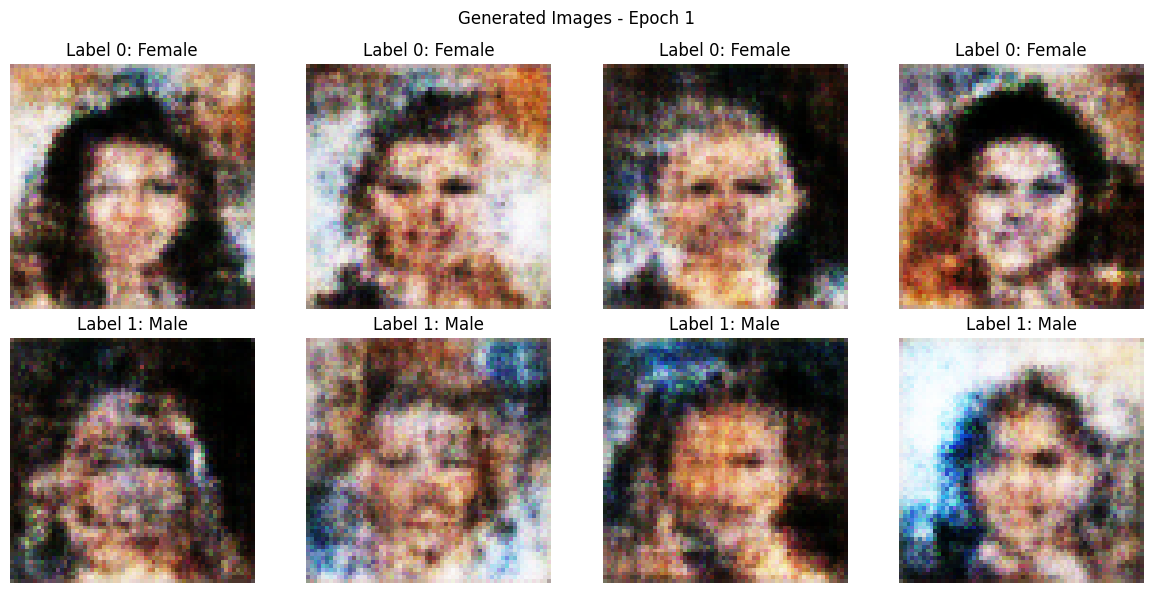

468/468 ━━━━━━━━━━━━━━━━━━━━ 220s 392ms/step - c_loss: -56.5303 - g_loss: -46.5411
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -16.6663 - g_loss: -288.7799

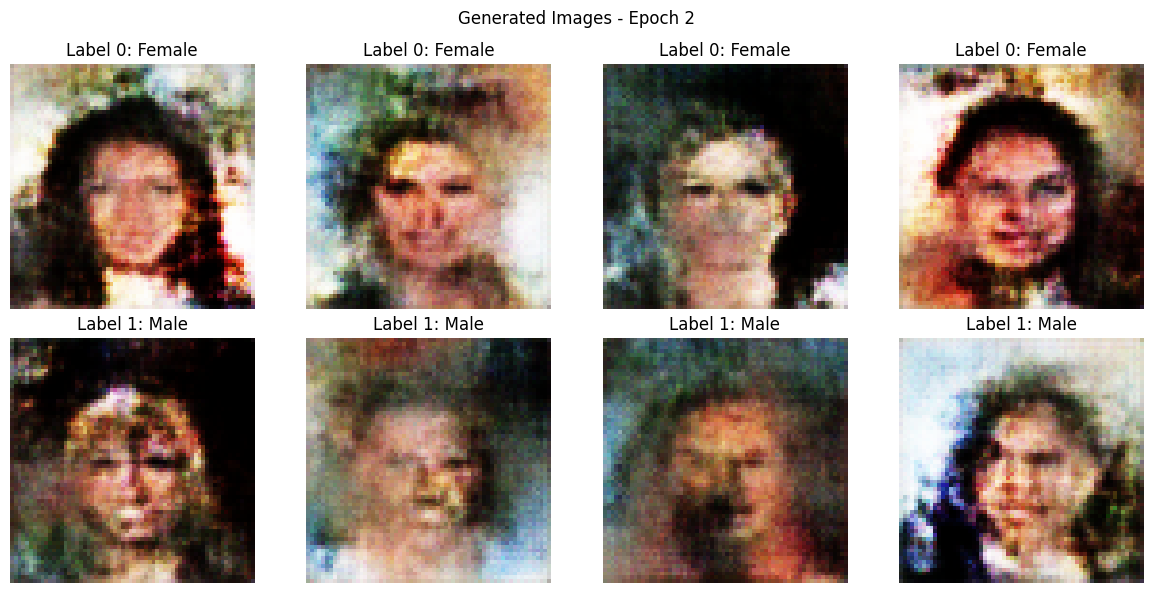

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -16.6641 - g_loss: -288.7049
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -12.8559 - g_loss: -121.0076

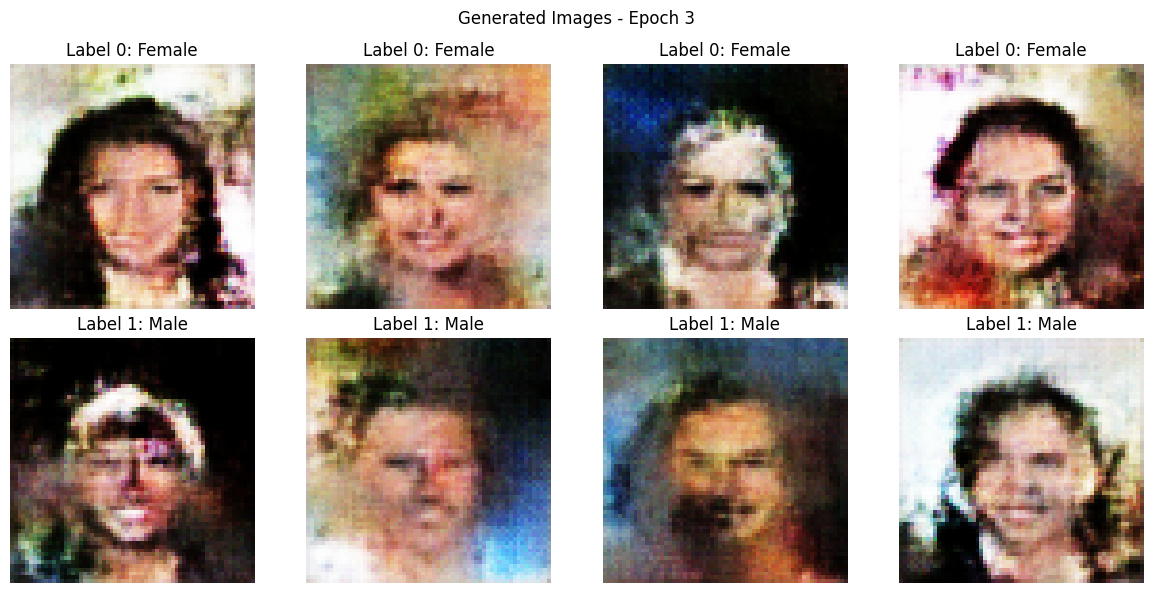

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -12.8550 - g_loss: -120.9697
Epoch 4/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -11.7578 - g_loss: -53.7172

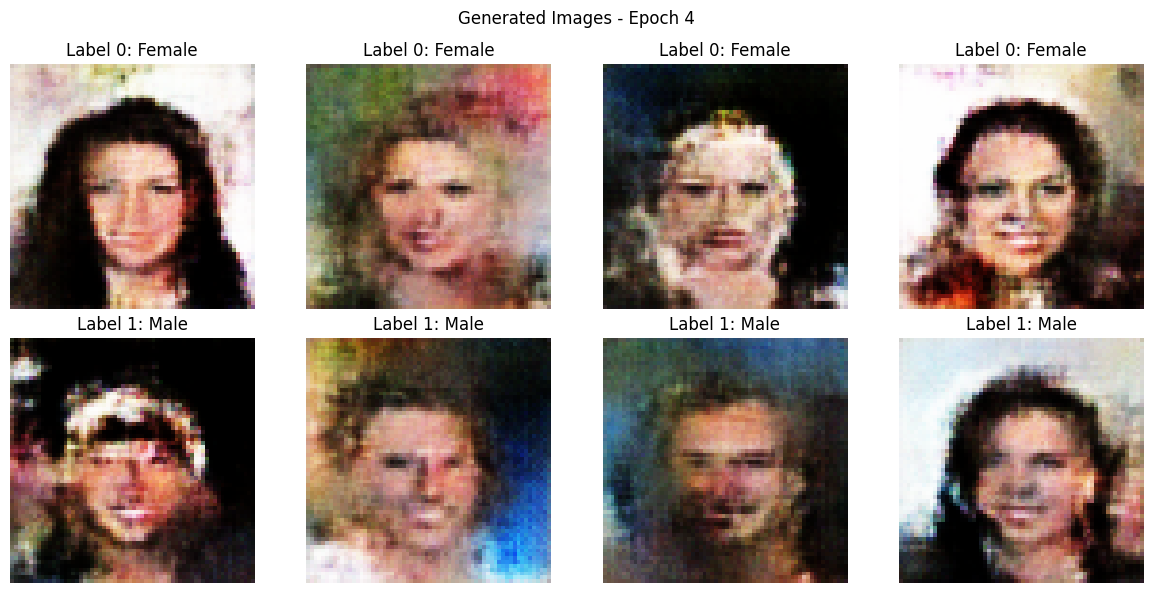

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -11.7573 - g_loss: -53.7041
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -11.3300 - g_loss: -33.0429

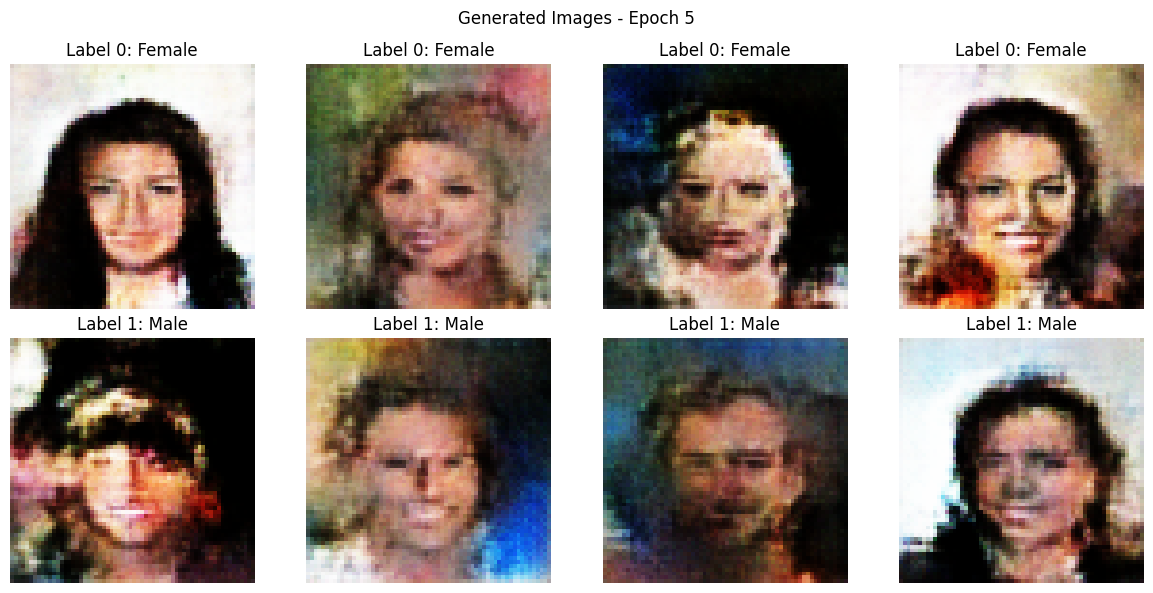

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -11.3299 - g_loss: -33.0259
Epoch 6/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -11.0874 - g_loss: -7.7364

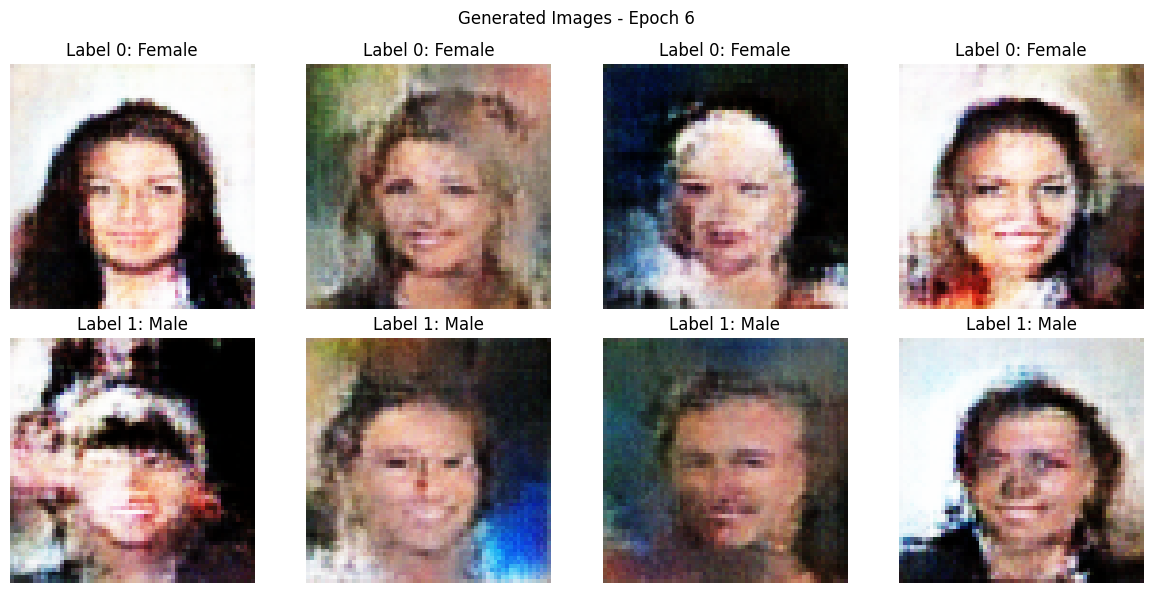

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -11.0872 - g_loss: -7.7316
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -10.8302 - g_loss: 2.8474

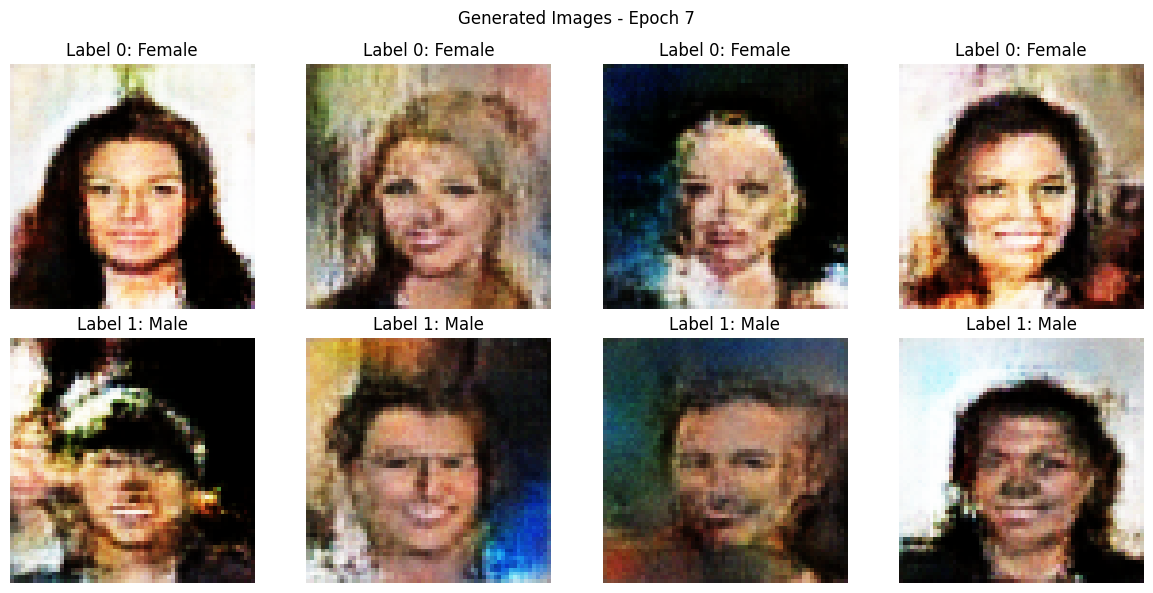

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -10.8301 - g_loss: 2.8525
Epoch 8/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -10.6914 - g_loss: 7.7119

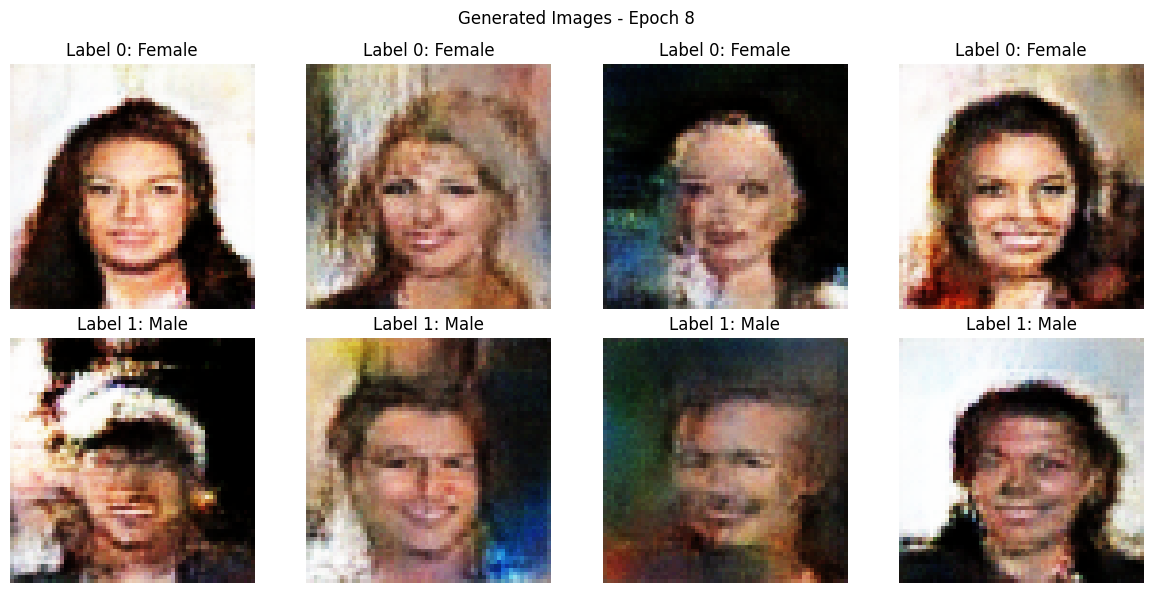

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -10.6913 - g_loss: 7.7124
Epoch 9/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -10.6215 - g_loss: 6.6635

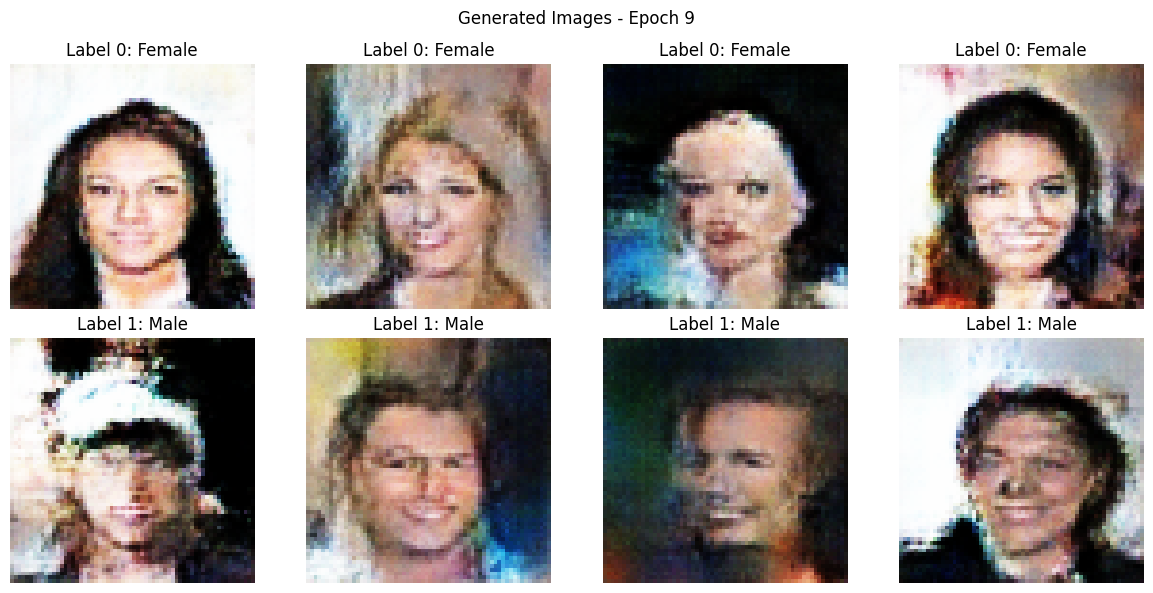

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -10.6212 - g_loss: 6.6671
Epoch 10/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -10.2649 - g_loss: 8.3821

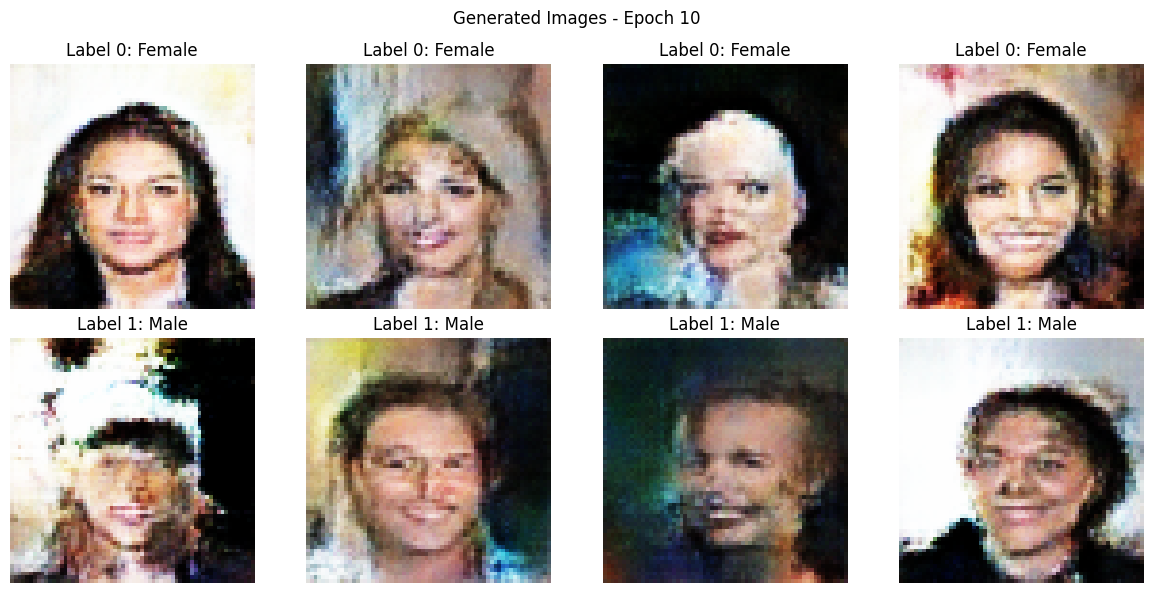

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -10.2649 - g_loss: 8.3844
Epoch 11/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -10.3124 - g_loss: 8.8615

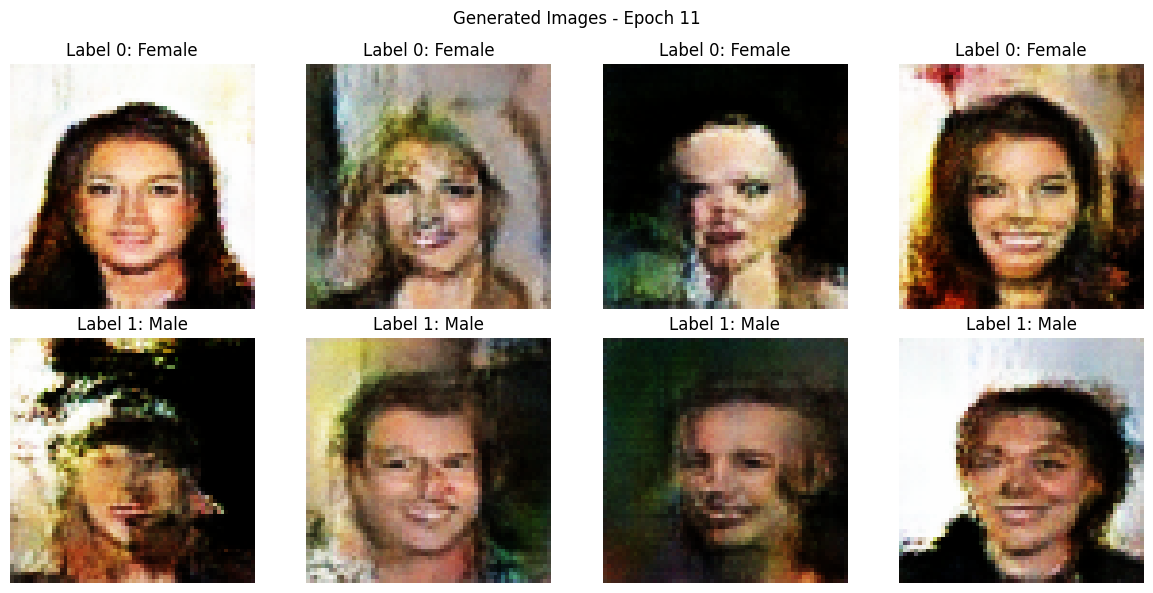

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -10.3123 - g_loss: 8.8627
Epoch 12/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.9740 - g_loss: 11.2154

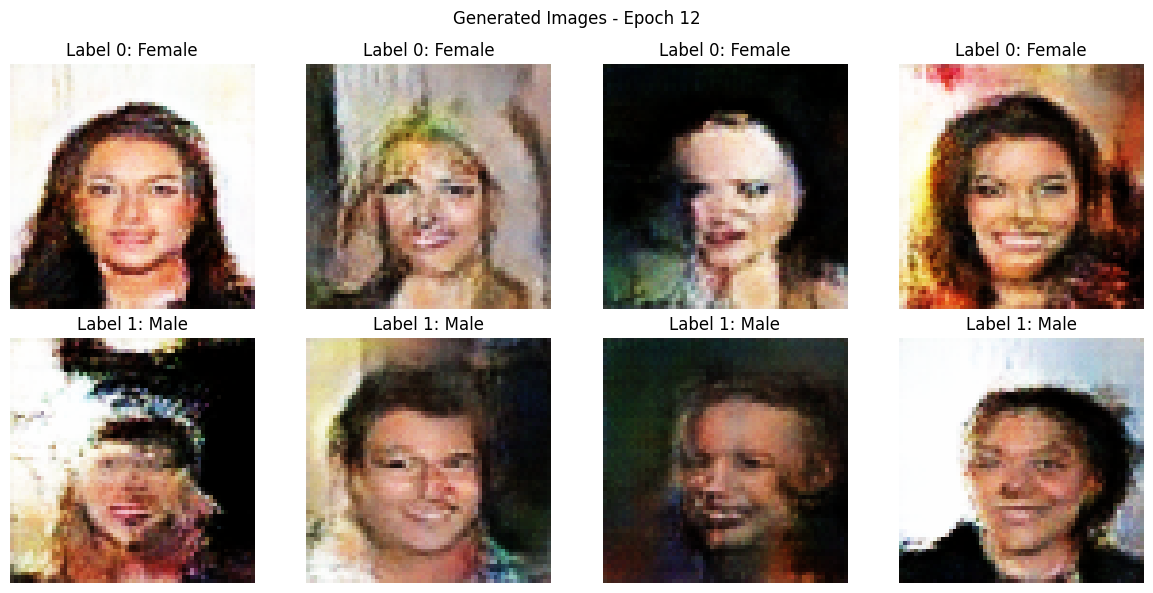

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.9740 - g_loss: 11.2166
Epoch 13/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.8709 - g_loss: 12.5500

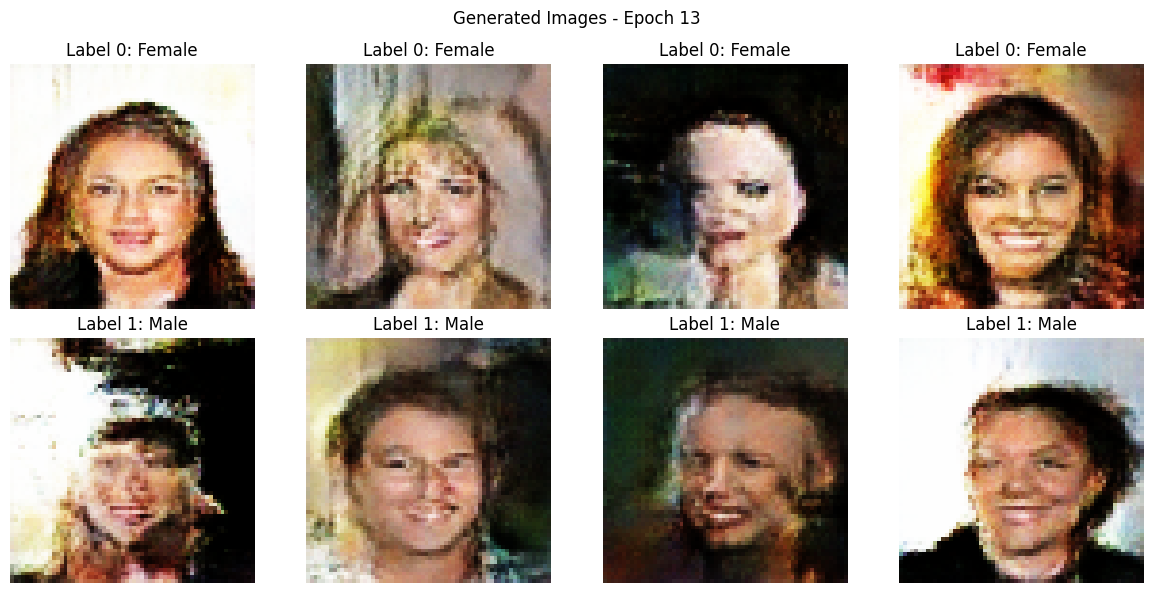

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.8709 - g_loss: 12.5515
Epoch 14/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.7087 - g_loss: 13.9491

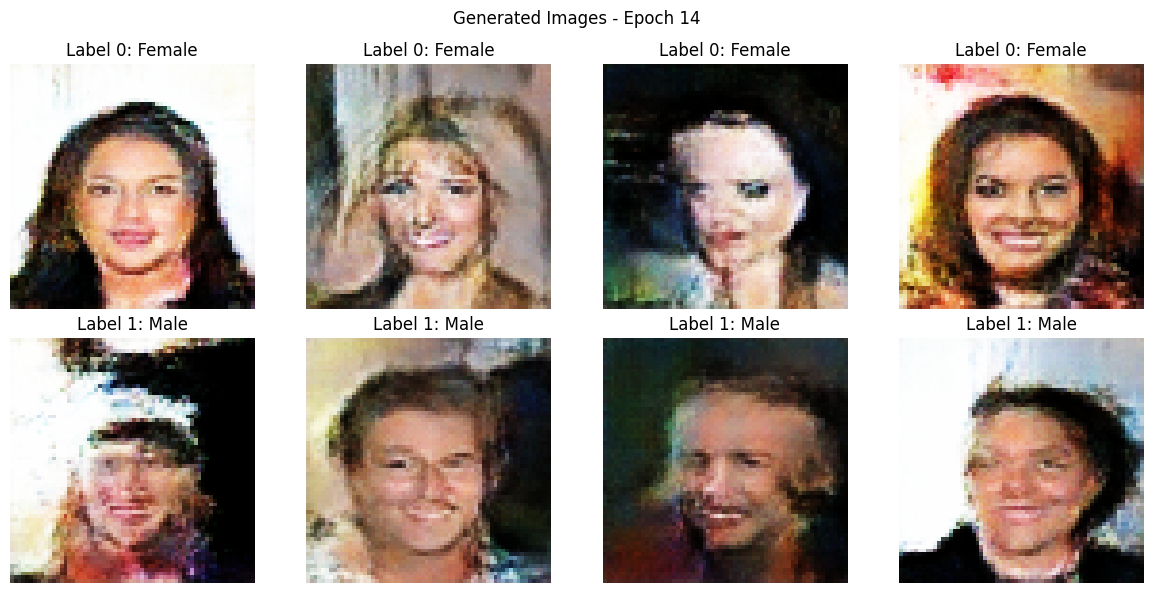

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.7087 - g_loss: 13.9496
Epoch 15/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.8297 - g_loss: 13.8855

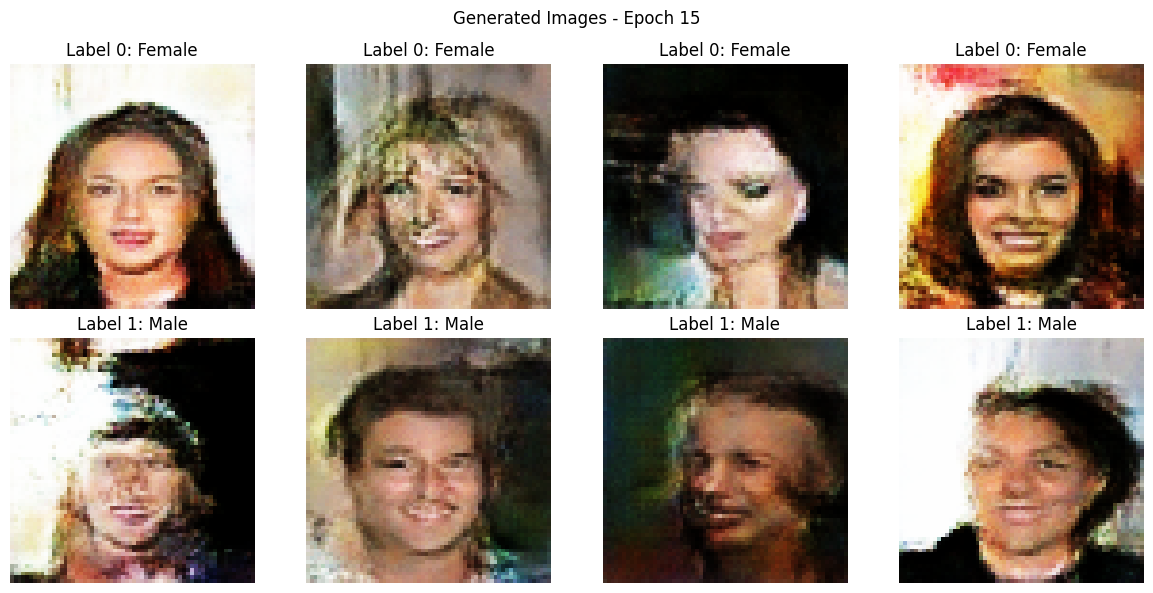

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.8295 - g_loss: 13.8862
Epoch 16/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.6089 - g_loss: 13.9449

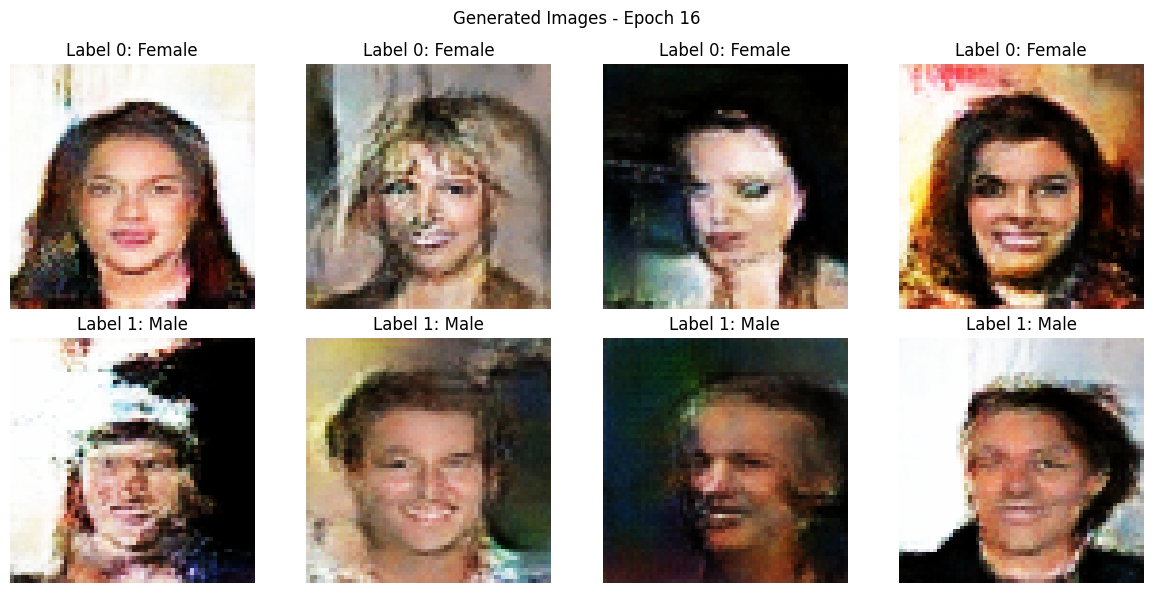

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.6087 - g_loss: 13.9448
Epoch 17/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.4256 - g_loss: 15.4435

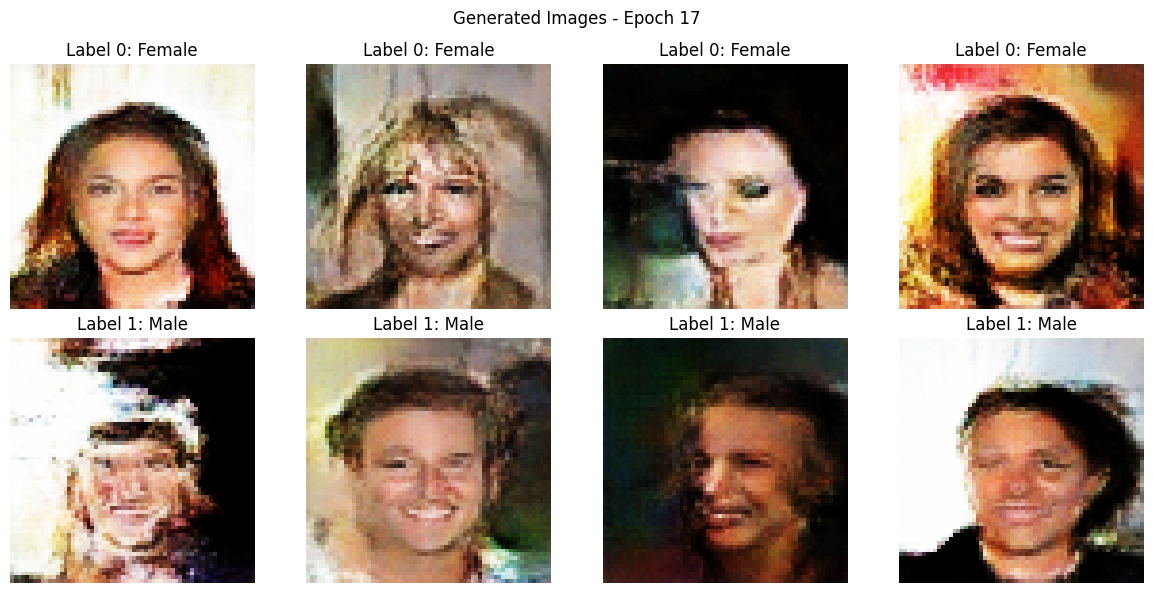

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.4256 - g_loss: 15.4448
Epoch 18/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.2646 - g_loss: 17.8393

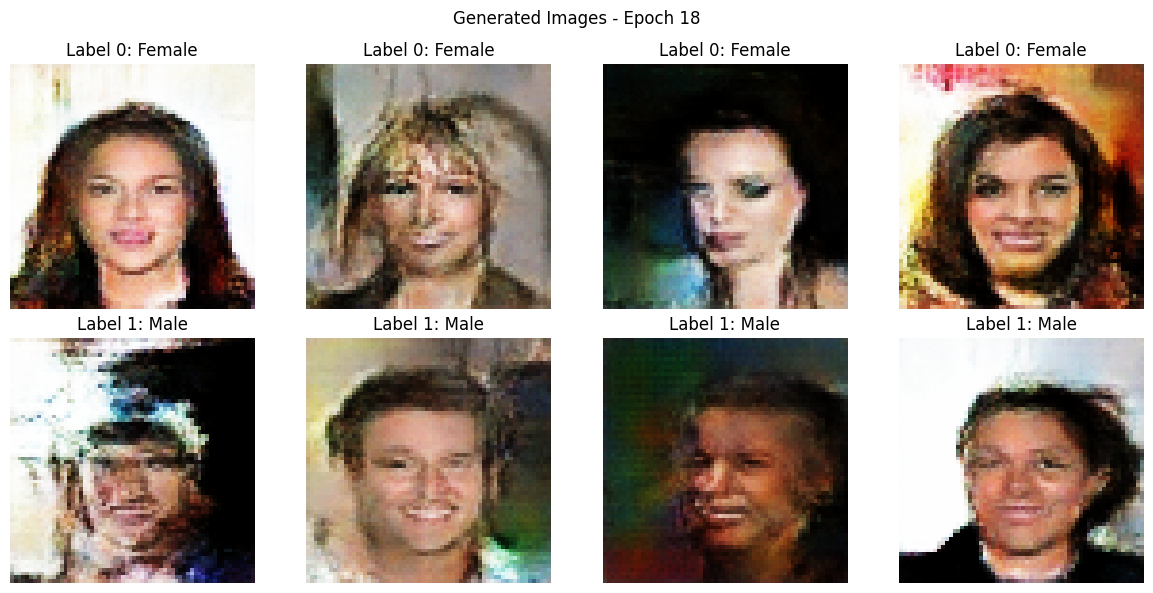

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.2646 - g_loss: 17.8404
Epoch 19/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - c_loss: -9.2684 - g_loss: 18.5316

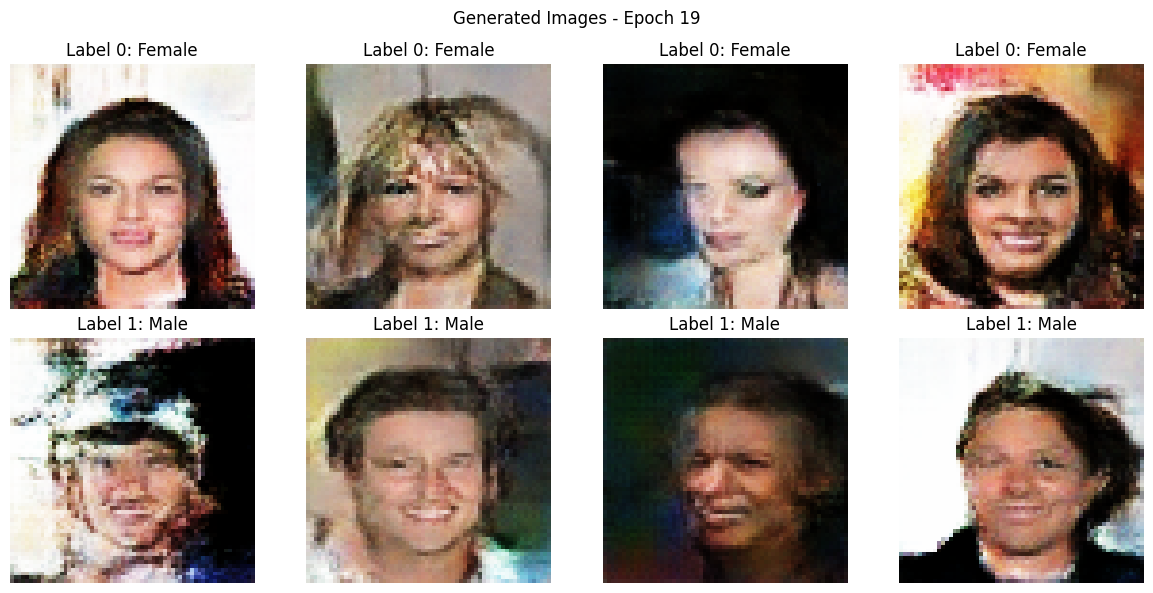

468/468 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - c_loss: -9.2683 - g_loss: 18.5323
Epoch 20/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - c_loss: -9.2813 - g_loss: 20.0902

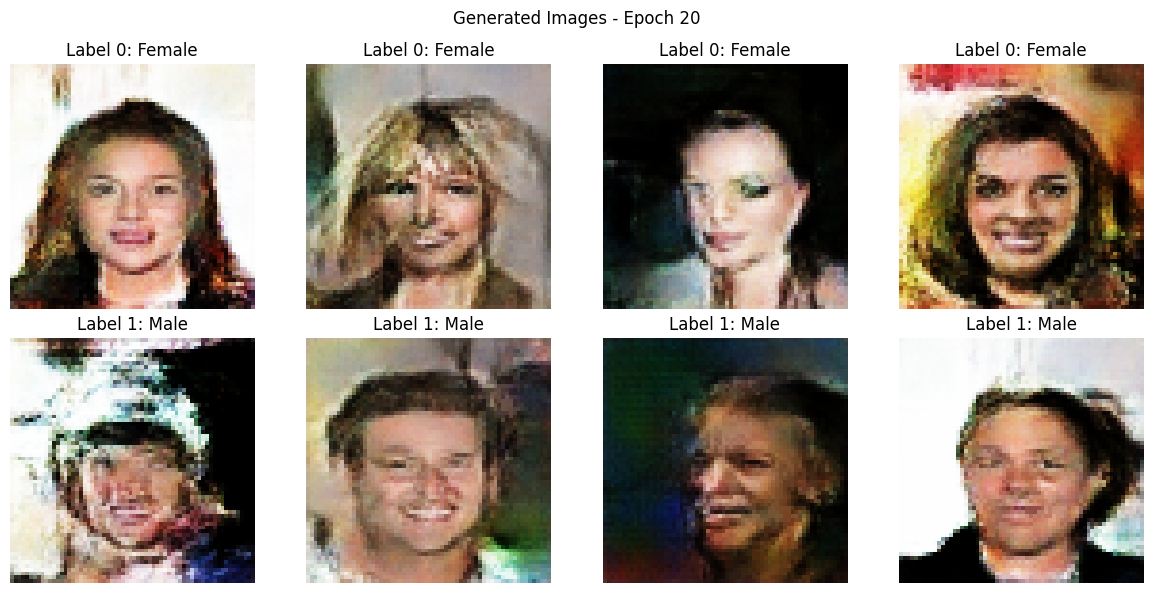

468/468 ━━━━━━━━━━━━━━━━━━━━ 184s 391ms/step - c_loss: -9.2812 - g_loss: 20.0909


In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# --- 6. CALLBACK MONITORING (REVISED) ---
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # Pre-seed noise and labels so we can see evolution on the same faces
        self.seed_latent = tf.random.normal(shape=(num_img * 2, latent_dim))
        # Convert seed_labels to TensorFlow Tensor with dtype=tf.int32
        self.seed_labels = tf.convert_to_tensor(np.array([0] * num_img + [1] * num_img).reshape(-1, 1), dtype=tf.int32)

    def on_epoch_end(self, epoch, logs=None):
        # Generate images using the fixed seed
        generated_images = self.model.generator([self.seed_latent, self.seed_labels], training=False)

        # DENORMALIZATION LOGIC:
        # If your generator ends with 'tanh', images are in range [-1, 1].
        # We scale them back to [0, 255] for display.
        generated_images = (generated_images + 1.0) * 127.5
        generated_images = np.clip(generated_images, 0, 255).astype("uint8")

        fig = plt.figure(figsize=(12, 6))
        for i in range(self.num_img * 2):
            plt.subplot(2, self.num_img, i + 1)
            # Handle grayscale vs RGB
            if generated_images.shape[-1] == 1:
                plt.imshow(generated_images[i, :, :, 0], cmap="gray")
            else:
                plt.imshow(generated_images[i])

            plt.axis("off")
            gender = "Female" if i < self.num_img else "Male"
            plt.title(f"Label {self.seed_labels[i][0]}: {gender}")

        plt.suptitle(f"Generated Images - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()
        plt.close() # Close to prevent memory accumulation in notebooks

# --- 7. INISIALISASI & TRAIN ---

# Ensure constants are defined
# LATENT_DIM = 128
# NUM_CLASSES = 2
# IMG_SHAPE = (64, 64, 3)

generator = build_generator(LATENT_DIM, NUM_CLASSES)
critic = build_critic(IMG_SHAPE, NUM_CLASSES)

# Important Check: Ensure your generator's last layer is:
# layers.Conv2DTranspose(..., activation='tanh')

wgan = WGAN_GP_CGAN(generator=generator, critic=critic, latent_dim=LATENT_DIM)

# Optimizer WGAN-GP configuration
# WGAN-GP is sensitive to learning rates. 0.0001 is often more stable than 0.0002.
c_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)
g_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)

wgan.compile(
    c_optimizer=c_opt,
    g_optimizer=g_opt
)

print("Starting Training...")
# Note: Ensure your 'dataset' yields images normalized to [-1, 1]
# example: ds = ds.map(lambda x, y: ((tf.cast(x, tf.float32) - 127.5) / 127.5, y))

wgan.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=4, latent_dim=LATENT_DIM)]
)